In [240]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adam
from keras.losses import mean_squared_error
from keras.initializers import RandomNormal
from math import sqrt
from tensorflow.random import set_random_seed
from keras import utils
from sklearn.linear_model import RidgeCV
from sklearn import linear_model, metrics   
from sklearn.linear_model import Lasso,Ridge  

#Import dataset
bf_file = 'C:/Users/Greg/Downloads/Movie_Revenue_Predictions.csv'
df = pd.read_csv(bf_file)

In [241]:
v = df.genres.apply(json.loads)

In [242]:
#Inspect Json load of generes
#v.head()
#Inspect import element
#df.head()
#df.columns
df.shape

(4803, 16)

In [243]:
#Import genere and id into dataframe
df2 = pd.DataFrame(
{
    'id' : df['id'].values.repeat(v.str.len(), axis=0),
    'genre' : np.concatenate(v.tolist())
})
#Inspect element
df2.head()

,id,genre
0,19995,"{'id': 28, 'name': 'Action'}"
1,19995,"{'id': 12, 'name': 'Adventure'}"
2,19995,"{'id': 14, 'name': 'Fantasy'}"
3,19995,"{'id': 878, 'name': 'Science Fiction'}"
4,285,"{'id': 12, 'name': 'Adventure'}"


Shape: 
(12160, 2)
unique: 
['Action' 'Adventure' 'Fantasy' 'Science Fiction' 'Crime' 'Drama'
 'Thriller' 'Animation' 'Family' 'Western' 'Comedy' 'Romance' 'Horror'
 'Mystery' 'History' 'War' 'Music' 'Documentary' 'Foreign' 'TV Movie']
describe: 
count     12160
unique       20
top       Drama
freq       2297
Name: genre, dtype: object


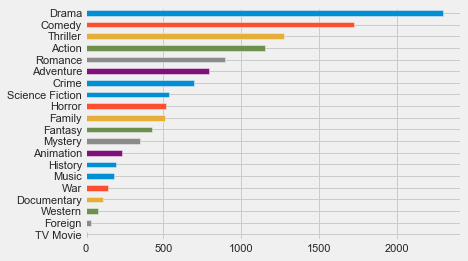

In [244]:
#Extract name element
df2['genre'] = df2['genre'].map(lambda x: x.get('name'))

#Inspect element
print('Shape: ')
print(df2.shape)
print('unique: ')
print(df2['genre'].unique())
print('describe: ')
print(df2['genre'].describe())

#seaborn left horzontal bar, counts
counts = df2['genre'].value_counts()
ax = counts.iloc[:20].plot(kind="barh")
ax.invert_yaxis()

In [245]:

#One hot encode genre
ohe = df2.set_index('id')\
        .genre.str.get_dummies()\
        .sum(level=0)\

print(ohe.head())

#arbitrarily drop one column for dummy vars
ohe.drop(['Drama'], inplace=True, axis=1)

        Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  \
id                                                                        
19995        1          1          0       0      0            0      0   
285          1          1          0       0      0            0      0   
206647       1          1          0       0      1            0      0   
49026        1          0          0       0      1            0      1   
49529        1          1          0       0      0            0      0   

        Family  Fantasy  Foreign  History  Horror  Music  Mystery  Romance  \
id                                                                           
19995        0        1        0        0       0      0        0        0   
285          0        1        0        0       0      0        0        0   
206647       0        0        0        0       0      0        0        0   
49026        0        0        0        0       0      0        0        0   
49529 

In [246]:
#ohe.head(8)
#ohe.shape
ohe.columns


Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')

In [247]:
#merge OHE genre with df
df3= pd.merge(df, ohe, on='id', how='left')

#Inspect element
print('Shape: ')
print(df3.shape)

print('is na: ')
print(df3[['Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']].isna().sum())

#fillna for data that did not have genre. inherantly they become 'Drama', the most frequent var
df3.update(df3[['Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']].fillna(0))

#drop genres. Have created dummy vars. na values inherantly become action
df3.drop(['genres'],axis=1,inplace=True)
df3.drop(['Action'],axis=1,inplace=True)
print(df3.columns)

Shape: 
(4803, 35)
is na: 
Adventure          28
Animation          28
Comedy             28
Crime              28
Documentary        28
Family             28
Fantasy            28
Foreign            28
History            28
Horror             28
Music              28
Mystery            28
Romance            28
Science Fiction    28
TV Movie           28
Thriller           28
War                28
Western            28
dtype: int64
Index(['title', 'tagline', 'revenue', 'budget', 'homepage', 'id', 'keywords',
       'original_language', 'overview', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')


In [248]:
print(df3.columns)


Index(['title', 'tagline', 'revenue', 'budget', 'homepage', 'id', 'keywords',
       'original_language', 'overview', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')


Shape: 
(13677, 2)
unique: 
['Ingenious Film Partners' 'Twentieth Century Fox Film Corporation'
 'Dune Entertainment' ... 'Front Street Pictures'
 'rusty bear entertainment' 'lucky crow films']
describe: 
count            13677
unique            5017
top       Warner Bros.
freq               319
Name: production_companies, dtype: object


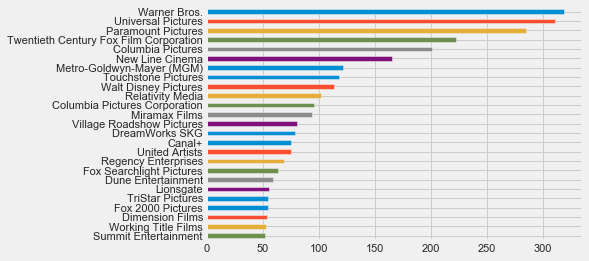

In [249]:
#production_companies. Pivot
v2 = df.production_companies.apply(json.loads)
df4 = pd.DataFrame(
{
    'id' : df['id'].values.repeat(v2.str.len(), axis=0),
    'production_companies' : np.concatenate(v2.tolist())
})

df4['production_companies'] = df4['production_companies'].map(lambda x: x.get('name'))


#Inspect element
print('Shape: ')
print(df4.shape)
print('unique: ')
print(df4['production_companies'].unique())
print('describe: ')
print(df4['production_companies'].describe())

#seaborn left horzontal bar, counts
counts = df4['production_companies'].value_counts()
ax = counts.iloc[:25].plot(kind="barh")
ax.invert_yaxis()

unique prod companies: 
count            13677
unique            5017
top       Warner Bros.
freq               319
Name: production_companies, dtype: object
              production_companies  count  Freq
0  "DIA" Productions GmbH & Co. KG      1     1
1                       1.85 Films      1     1
2                  10 West Studios      1     1
3                        100 Bares      2     2
4               1019 Entertainment      1     1
df_prod shape: 
(4829, 3)


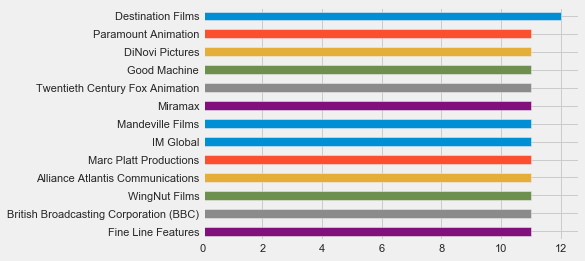

In [250]:
#group by for counts of production companies per movie
df4['count']=df4.groupby("production_companies")['production_companies'].transform('count')

df4[["count"]] = df4[["count"]].apply(pd.to_numeric)

#considered dropping. decided against since using bayesian models
df5 = df4[df4['count'] > 10]

#visualize data and investigate if we are going to bin
####################################################################
#view unique prod companies and describe 
print('unique prod companies: ')
print(df4['production_companies'].describe())

#only view top 
#df_prod = df4[df4['count'] < 10]


#get unique and count
df_prod2 = df4.groupby(['production_companies', 'count']).size().reset_index(name='Freq')

print(df_prod2.head())

df_prod3 = df_prod2[df_prod2['count'] < 10]
print('df_prod shape: ')
print(df_prod3.shape)

#binning prod companies 1-10. 4829 out of 5017

#sns.catplot(x="count", y="production_companies", kind="swarm", data=df_prod2);
####################################################################


#look at tail end of selected data
#seaborn left horzontal bar, counts
counts = df5['production_companies'].value_counts()
ax = counts.iloc[150:180].plot(kind="barh")
ax.invert_yaxis()

In [251]:
%%time
#One hot encode production companies
ohe2 = df5.set_index('id')\
        .production_companies.str.get_dummies()\
        .sum(level=0)\

#drop one column, low value column
ohe2.drop(['Scion Films'], inplace=True, axis=1)

Wall time: 5.49 s


In [252]:
#print(ohe2.shape)
#print(ohe2.head())

#get all columns
cols = ohe2.columns.tolist()
print(cols)

['1492 Pictures', '21 Laps Entertainment', '2929 Productions', '3 Arts Entertainment', '40 Acres & A Mule Filmworks', 'Alcon Entertainment', 'Alliance Atlantis Communications', 'Alliance Films', 'Amblin Entertainment', 'American Zoetrope', 'Anonymous Content', 'Apatow Productions', 'Atlas Entertainment', 'BBC Films', 'Bad Hat Harry Productions', 'BenderSpink', 'Big Screen Productions', 'Blumhouse Productions', 'British Broadcasting Corporation (BBC)', 'CBS Films', 'Canal+', 'Castle Rock Entertainment', 'Centre National de la Cinématographie (CNC)', 'Channel Four Films', 'Cinergi Pictures Entertainment', 'Ciné+', 'Columbia Pictures', 'Columbia Pictures Corporation', 'Constantin Film Produktion', 'Cruise/Wagner Productions', 'DC Comics', 'DC Entertainment', 'Dark Castle Entertainment', 'Davis Entertainment', 'Davis-Films', 'Dentsu', 'Destination Films', 'Di Bonaventura Pictures', 'DiNovi Pictures', 'Dimension Films', 'Dino De Laurentiis Company', "Donners' Company", 'Double Feature Films

In [253]:
#merge encoded production companies back with dataset
df6= pd.merge(df3, ohe2, on='id', how='left')

print(df6.shape)

#by filling with 0 we make all na values equal to 'Scion Films', a low count var
df6.update(df6[['1492 Pictures', '21 Laps Entertainment', '2929 Productions', '3 Arts Entertainment',
                '40 Acres & A Mule Filmworks', 'Alcon Entertainment', 'Alliance Atlantis Communications', 
                'Alliance Films', 'Amblin Entertainment', 'American Zoetrope', 'Anonymous Content', 
                'Apatow Productions', 'Atlas Entertainment', 'BBC Films', 'Bad Hat Harry Productions', 'BenderSpink', 
                'Big Screen Productions', 'Blumhouse Productions', 'British Broadcasting Corporation (BBC)', 'CBS Films', 
                'Canal+', 'Castle Rock Entertainment', 'Centre National de la Cinématographie (CNC)', 'Channel Four Films', 
                'Cinergi Pictures Entertainment', 'Ciné+', 'Columbia Pictures', 'Columbia Pictures Corporation', 
                'Constantin Film Produktion', 'Cruise/Wagner Productions', 'DC Comics', 'DC Entertainment', 
                'Dark Castle Entertainment', 'Davis Entertainment', 'Davis-Films', 'Dentsu', 'Destination Films', 
                'Di Bonaventura Pictures', 'DiNovi Pictures', 'Dimension Films', 'Dino De Laurentiis Company',
                "Donners' Company", 'Double Feature Films', 'DreamWorks Animation', 'DreamWorks SKG', 'Dune Entertainment', 
                'Dune Entertainment III', 'Emmett/Furla Films', 'Endgame Entertainment', 'Eon Productions', 
                'Epsilon Motion Pictures', 'Escape Artists', 'EuropaCorp', 'Film4', 'Fine Line Features', 'Focus Features',
                'Fox 2000 Pictures', 'Fox Searchlight Pictures', 'France 2 Cinéma', 'Franchise Pictures', 
                'Gary Sanchez Productions', 'Gold Circle Films', 'Goldcrest Pictures', 'Good Machine',
                'Happy Madison Productions', 'Hollywood Pictures', 'IM Global', 'Icon Entertainment International', 
                'Imagenation Abu Dhabi FZ', 'Imagine Entertainment', 'Impact Pictures', 'Ingenious Film Partners', 
                'Ingenious Media', 'Intermedia Films', 'Jerry Bruckheimer Films', 'Jersey Films',
                'Kennedy/Marshall Company, The', 'LStar Capital', 'Lakeshore Entertainment', 'Legendary Pictures',
                'Lions Gate Films', 'Lionsgate', 'Lucasfilm', 'MTV Films', 'Malpaso Productions', 'Mandate Pictures',
                'Mandeville Films', 'Marc Platt Productions', 'Marvel Enterprises', 'Marvel Studios',
                'Media Rights Capital', "Mel's Cite du Cinema", 'Metro-Goldwyn-Mayer (MGM)', 'Millennium Films',
                'Mirage Enterprises', 'Miramax', 'Miramax Films', 'Morgan Creek Productions', 'Mosaic Media Group',
                'Moving Picture Company (MPC)', 'Mutual Film Company', 'NPV Entertainment', 'New Line Cinema',
                'New Regency Pictures', 'Nickelodeon Movies', 'Nu Image Films', 'Original Film', 'Orion Pictures',
                'Paramount Animation', 'Paramount Pictures', 'Paramount Vantage', 'Participant Media', 'Pathé',
                'Phoenix Pictures', 'Pixar Animation Studios', 'Plan B Entertainment', 'Platinum Dunes', 
                'PolyGram Filmed Entertainment', 'Radar Pictures', 'RatPac-Dune Entertainment', 'Regency Enterprises',
                'Relativity Media', 'Revolution Studios', 'Revolution Sun Studios', 'Robert Simonds Productions',
                'Saturn Films', 'Scott Free Productions', 'Scott Rudin Productions', 'Screen Gems',
                'Sidney Kimmel Entertainment', 'Silver Pictures', 'Sony Pictures Animation',
                'Sony Pictures Classics', 'Spyglass Entertainment', 'Studio Babelsberg', 'Studio Canal', 'StudioCanal',
                'Summit Entertainment', 'Sunswept Entertainment', 'TF1 Films Production', 'TSG Entertainment',
                'The Kennedy/Marshall Company', 'The Weinstein Company', 'Tim Burton Productions', 
                'Touchstone Pictures', 'TriStar Pictures', 'Tribeca Productions', 'Twentieth Century Fox Animation',
                'Twentieth Century Fox Film Corporation', 'Téléfilm Canada', 'UK Film Council', 'United Artists',
                'Universal Pictures', 'Vertigo Entertainment', 'Village Roadshow Pictures', 'Walden Media',
                'Walt Disney Pictures', 'Warner Bros.', 'Wild Bunch', 'WingNut Films', 'Working Title Films',
                'Worldview Entertainment']].fillna(0))

#print(df3.columns)
#print(df4.columns)
#print(df6.head())
print(df6.shape)
#print(df6.columns)
#df.update(df[['a','b','c']].fillna(0))

(4803, 195)
(4803, 195)


In [254]:
#drop unneeded columns
# title = extraneous
#tagline = Possible word tokenization (feature vector). Idea for different approach
#budget = requirements said not to use
#keywords = Possible word tokenization (feature vector). Idea for different approach
#overview = Possible word tokenization (feature vector). Idea for different approach
#status = extraneous
#production_companies = one hot encoded

df7=df6.drop(['title', 'tagline', 'budget','keywords','overview','status','production_companies'], axis=1)
#df7.columns
df7.shape

(4803, 188)

       id                         spoken_languages
0   19995   {'iso_639_1': 'en', 'name': 'English'}
1   19995   {'iso_639_1': 'es', 'name': 'Español'}
2     285   {'iso_639_1': 'en', 'name': 'English'}
3  206647  {'iso_639_1': 'fr', 'name': 'Français'}
4  206647   {'iso_639_1': 'en', 'name': 'English'}


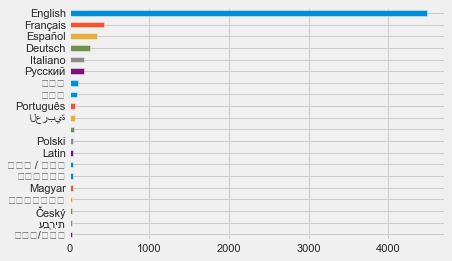

In [255]:
#spoken languages. pivot
v3 = df.spoken_languages.apply(json.loads)
df8 = pd.DataFrame(
{
    'id' : df['id'].values.repeat(v3.str.len(), axis=0),
    'spoken_languages' : np.concatenate(v3.tolist())
})
print(df8.head())

df8['spoken_languages'] = df8['spoken_languages'].map(lambda x: x.get('name'))

#seaborn left horzontal bar, counts
#outside of top 20 it's very minimal
counts = df8['spoken_languages'].value_counts()
ax = counts.iloc[:20].plot(kind="barh")
ax.invert_yaxis()

In [256]:
#print(df.head)
print(df8.shape)
print(df8.head())
print(df8.spoken_languages.unique())



(6937, 2)
       id spoken_languages
0   19995          English
1   19995          Español
2     285          English
3  206647         Français
4  206647          English
['English' 'Español' 'Français' 'Italiano' 'Deutsch' 'Türkçe' 'ελληνικά'
 '普通话' 'ภาษาไทย' 'Íslenska' 'Pусский' 'svenska' 'Română' '日本語' 'Latin'
 'हिन्दी' 'Português' '' 'فارسی' 'اردو' 'العربية' 'Český' '广州话 / 廣州話'
 '한국어/조선말' 'Norsk' 'தமிழ்' 'עִבְרִית' 'Dansk' 'Nederlands' 'Afrikaans'
 'Gaeilge' 'Somali' 'suomi' 'Kiswahili' 'български език' 'Tiếng Việt'
 'Magyar' 'Український' 'Esperanto' 'Polski' 'ਪੰਜਾਬੀ' 'Eesti' 'shqip'
 'Srpski' 'Bosanski' 'Hrvatski' 'Slovenčina' 'қазақ' 'తెలుగు' 'Cymraeg'
 'Wolof' 'isiZulu' 'پښتو' 'No Language' 'Galego' 'ქართული' 'বাংলা'
 'Català' '??????' 'Bahasa indonesia' 'Bamanankan' 'Slovenščina']


In [257]:
df8['count']=df8.groupby("spoken_languages")['spoken_languages'].transform('count')

df8[["count"]] = df8[["count"]].apply(pd.to_numeric)

#print(df8.spoken_languages.unique())
#print(df8.shape)
#print(df8.head(100))

##Keep languages with over 40 occurances.
#Decided to keep all information
#df9.drop_duplicates()
#df9 = df8[df8['count'] > 39]

df9=df8

#One hot encode spoken languages
ohe3 = df9.set_index('id')\
        .spoken_languages.str.get_dummies()\
        .sum(level=0)\

#get all columns
cols = ohe3.columns.tolist()
print(cols)

#drop one column for one hot encoding 
ohe3.drop(['??????'], inplace=True, axis=1)
#print(ohe3.head())


['??????', 'Afrikaans', 'Bahasa indonesia', 'Bamanankan', 'Bosanski', 'Català', 'Cymraeg', 'Dansk', 'Deutsch', 'Eesti', 'English', 'Español', 'Esperanto', 'Français', 'Gaeilge', 'Galego', 'Hrvatski', 'Italiano', 'Kiswahili', 'Latin', 'Magyar', 'Nederlands', 'No Language', 'Norsk', 'Polski', 'Português', 'Pусский', 'Română', 'Slovenčina', 'Slovenščina', 'Somali', 'Srpski', 'Tiếng Việt', 'Türkçe', 'Wolof', 'isiZulu', 'shqip', 'suomi', 'svenska', 'Íslenska', 'Český', 'ελληνικά', 'Український', 'български език', 'қазақ', 'עִבְרִית', 'اردو', 'العربية', 'فارسی', 'پښتو', 'हिन्दी', 'বাংলা', 'ਪੰਜਾਬੀ', 'தமிழ்', 'తెలుగు', 'ภาษาไทย', 'ქართული', '广州话 / 廣州話', '日本語', '普通话', '한국어/조선말']


In [258]:
#merge back into dataset
df10= pd.merge(df7, ohe3, on='id', how='left')

print(df10.shape)

#by filling with 0 we make all na values equal to '??????', a low count var
df10.update(df10[[ 'Afrikaans', 'Bahasa indonesia', 'Bamanankan', 'Bosanski', 'Català', 'Cymraeg', 'Dansk', 'Deutsch', 
                  'Eesti', 'English', 'Español', 'Esperanto', 'Français', 'Gaeilge', 'Galego', 'Hrvatski', 'Italiano',
                  'Kiswahili', 'Latin', 'Magyar', 'Nederlands', 'No Language', 'Norsk', 'Polski', 'Português', 'Pусский',
                  'Română', 'Slovenčina', 'Slovenščina', 'Somali', 'Srpski', 'Tiếng Việt', 'Türkçe', 'Wolof', 'isiZulu',
                  'shqip', 'suomi', 'svenska', 'Íslenska', 'Český', 'ελληνικά', 'Український', 'български език', 'қазақ',
                  'עִבְרִית', 'اردو', 'العربية', 'فارسی', 'پښتو', 'हिन्दी', 'বাংলা', 'ਪੰਜਾਬੀ', 'தமிழ்', 'తెలుగు', 'ภาษาไทย', 
                  'ქართული', '广州话 / 廣州話', '日本語', '普通话', '한국어/조선말']].fillna(0))

print(df10.shape)
#print(df7.shape)
#print(df10.columns)

(4803, 248)
(4803, 248)


In [259]:
#drop old spoken_languages column
print(df10.columns)
df10.drop(['spoken_languages'],axis=1,inplace=True)
#print(df10[['Deutsch', 'English', 'Español',
#       'Français', 'Italiano', 'Latin', 'Magyar', 'Polski', 'Português',
#       'Pусский', 'العربية', 'हिन्दी', 'ภาษาไทย', '广州话 / 廣州話', '日本語', '普通话']].head(100))

Index(['revenue', 'homepage', 'id', 'original_language',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'Adventure', 'Animation',
       ...
       'বাংলা', 'ਪੰਜਾਬੀ', 'தமிழ்', 'తెలుగు', 'ภาษาไทย', 'ქართული', '广州话 / 廣州話',
       '日本語', '普通话', '한국어/조선말'],
      dtype='object', length=248)


3091
1712
[1 0]


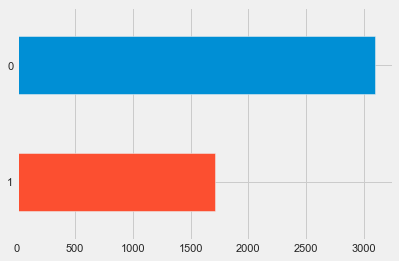

In [260]:
#begin homepage boolean work

print(df10["homepage"].isna().sum())
print(df10["homepage"].notnull().sum())

#no need to drop anything or create 2 dummy cols. It's inherant that if not 1 than 0. 
df10['homepage2'] = np.where(df['homepage'].isnull(), 0, 1)

print(df10.homepage2.unique()) 

#seaborn left horzontal bar, counts
#outside of top 20 it's very minimal
counts = df10['homepage2'].value_counts()
ax = counts.iloc[:20].plot(kind="barh")
ax.invert_yaxis()

#print(df10["homepage"].isna().sum())
#print(df10["homepage"].notnull().sum())

#print(df10["homepage"])#.head(1000))
#print(df10.head())

In [261]:
#drop old homepage column
df11 = df10.drop(['homepage'], axis = 1)
#print(df11.columns.unique())

['en' 'ja' 'fr' 'zh' 'es' 'de' 'hi' 'ru' 'ko' 'te' 'cn' 'it' 'nl' 'ta'
 'sv' 'th' 'da' 'xx' 'hu' 'cs' 'pt' 'is' 'tr' 'nb' 'af' 'pl' 'he' 'ar'
 'vi' 'ky' 'id' 'ro' 'fa' 'no' 'sl' 'ps' 'el']
0
4803
en    4505
fr      70
es      32
de      27
zh      27
hi      19
ja      16
it      14
cn      12
ko      11
ru      11
pt       9
da       7
sv       5
nl       4
fa       4
th       3
he       3
id       2
ar       2
ta       2
cs       2
ro       2
pl       1
nb       1
te       1
no       1
af       1
ps       1
el       1
vi       1
sl       1
tr       1
xx       1
ky       1
hu       1
is       1
Name: original_language, dtype: int64
      revenue      id original_language  \
0  2787965087   19995                en   
1   961000000     285                en   
2   880674609  206647                en   
3  1084939099   49026                en   
4   284139100   49529                en   

                                production_countries release_date  runtime  \
0  [{"iso_3166_1": "US

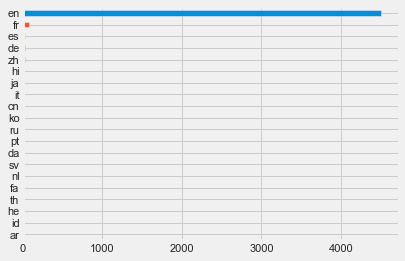

In [262]:
#begin original_language work
#view data
print(df11.original_language.unique())
print(df11["original_language"].isna().sum())
print(df11["original_language"].notnull().sum())
print(df11['original_language'].value_counts())
print(df11.head())
#no nulls in dataset

counts = df11['original_language'].value_counts()
ax = counts.iloc[:20].plot(kind="barh")
ax.invert_yaxis()

In [263]:
#decided to not bin. 
#deleting non english original language. the rest are outliers.
df11 = df11.drop(df11[df11.original_language != 'en'].index)
print(df11['original_language'].value_counts())

en    4505
Name: original_language, dtype: int64


In [264]:
#Group by count of languages
df11['count']=df11.groupby("original_language")['original_language'].transform('count')

#df12[["count"]] = df12[["count"]].apply(pd.to_numeric)
#print(df11)

In [265]:
#view data
print(df11['count'].unique())
print(df11.shape)
#df11.columns

[4505]
(4505, 248)


In [266]:
#decided not to bin and keep 
#bin languages by count
bins = [0,10000]
df11['binned_Orig_lang'] = np.searchsorted(bins, df11['count'].values)
#print (df11)


In [267]:
#Drop Count and orininal_language. Was used for binning.
#print(df11.columns)
df11.drop(['count','original_language'],axis=1,inplace=True)
df11.columns

Index(['revenue', 'id', 'production_countries', 'release_date', 'runtime',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       ...
       'தமிழ்', 'తెలుగు', 'ภาษาไทย', 'ქართული', '广州话 / 廣州話', '日本語', '普通话',
       '한국어/조선말', 'homepage2', 'binned_Orig_lang'],
      dtype='object', length=247)

In [268]:
print(df11["binned_Orig_lang"].isna().sum())   
print(df11["binned_Orig_lang"].notnull().sum())
print(df11['binned_Orig_lang'].unique())

0
4505
[1]


In [269]:
#####################################################################################################
#since only kept english original_lang we are going to drop column. now unneeded binning commented out
#####################################################################################################
#create dummy variables for original language
#columns titled 6,2,5,3,2
 
#for elem in df11['binned_Orig_lang'].unique():
    #df11[str(elem)] = df11['binned_Orig_lang'] == elem

#drop binned col and 1 arbitrary col for dummy var
df11.drop(['binned_Orig_lang'],axis=1,inplace=True)

#get all columns
cols = df11.columns.tolist()
print(cols)

['revenue', 'id', 'production_countries', 'release_date', 'runtime', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', '1492 Pictures', '21 Laps Entertainment', '2929 Productions', '3 Arts Entertainment', '40 Acres & A Mule Filmworks', 'Alcon Entertainment', 'Alliance Atlantis Communications', 'Alliance Films', 'Amblin Entertainment', 'American Zoetrope', 'Anonymous Content', 'Apatow Productions', 'Atlas Entertainment', 'BBC Films', 'Bad Hat Harry Productions', 'BenderSpink', 'Big Screen Productions', 'Blumhouse Productions', 'British Broadcasting Corporation (BBC)', 'CBS Films', 'Canal+', 'Castle Rock Entertainment', 'Centre National de la Cinématographie (CNC)', 'Channel Four Films', 'Cinergi Pictures Entertainment', 'Ciné+', 'Columbia Pictures', 'Columbia Pictures Corporation', 'Constantin Film Produktion', 'Cruise/Wagner Producti

In [270]:
print(df11.shape)
print(df11.columns)

(4505, 246)
Index(['revenue', 'id', 'production_countries', 'release_date', 'runtime',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       ...
       'ਪੰਜਾਬੀ', 'தமிழ்', 'తెలుగు', 'ภาษาไทย', 'ქართული', '广州话 / 廣州話', '日本語',
       '普通话', '한국어/조선말', 'homepage2'],
      dtype='object', length=246)


In [271]:
#extract year from release date


#df.drop(df[df.score < 50].index, inplace=True)
#data.dropna(subset=['Age'], inplace=True)

#drop null release date
print(df11['release_date'].isna().sum())
df11 = df11.dropna(axis=0, subset=['release_date'])
print(df11['release_date'].isna().sum())

df11['year'] = pd.DatetimeIndex(df11['release_date']).year

#print(df11['year'].unique())

#extract month from release date
df11['month'] = pd.DatetimeIndex(df11['release_date']).month
#print(df11['month'].unique())

#print(df11['month'].value_counts())

#identify nulls
print('month is null: ')
print(df11["month"].isna().sum())
print(df11["month"].notnull().sum())
print('distinct month and count: ')
print(df11['month'].value_counts())
print('median for month: ')
print(df11['month'].median())
##fill na month with median

print('year is null: ')
print(df11["year"].isna().sum())
print(df11["year"].notnull().sum())
print('year median: ')
print(df11['year'].median())
#fill na year with median

1
0
month is null: 
0
4504
distinct month and count: 
9     551
10    442
12    427
8     385
6     371
3     354
1     354
7     338
5     335
4     329
11    314
2     304
Name: month, dtype: int64
median for month: 
7.0
year is null: 
0
4504
year median: 
2006.0


C:\Users\Greg\Anaconda3\envs\ai\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


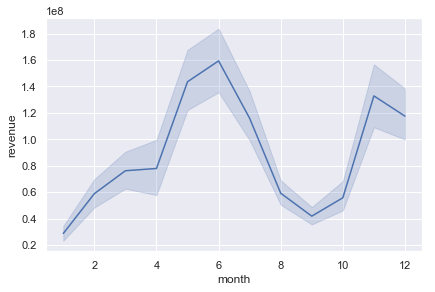

In [272]:
#import seaborn as sns; sns.set()
#import matplotlib.pyplot as plt
#ps = sns.lineplot(x='year', y="revenue", data=df11)

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ps = sns.lineplot(x='month', y="revenue", data=df11)

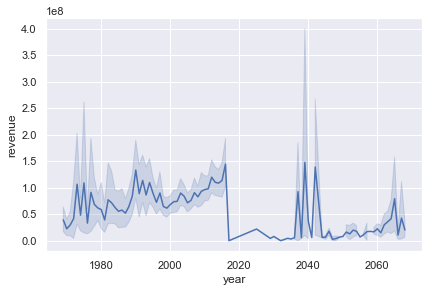

In [273]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ps = sns.lineplot(x='year', y="revenue", data=df11)

#if year is > 2019 make 2019

In [274]:

df_year = df11['year'].loc[df11['year'] > 2019]
print(df_year.value_counts())

#print(df_year)
#print(df11['year'].unique)
#132 values over 2019

2068    9
2064    8
2063    8
2062    7
2065    7
2066    5
2040    5
2061    5
2045    4
2052    4
2053    4
2047    3
2059    3
2060    3
2056    3
2054    3
2051    3
2046    3
2067    3
2048    3
2039    3
2037    2
2049    2
2044    2
2042    2
2038    2
2057    2
2036    2
2033    2
2058    1
2029    1
2035    1
2055    1
2034    1
2041    1
2032    1
2050    1
2030    1
2025    1
Name: year, dtype: int64


In [275]:
print(df11)

         revenue      id                               production_countries  \
0     2787965087   19995  [{"iso_3166_1": "US", "name": "United States o...   
1      961000000     285  [{"iso_3166_1": "US", "name": "United States o...   
2      880674609  206647  [{"iso_3166_1": "GB", "name": "United Kingdom"...   
3     1084939099   49026  [{"iso_3166_1": "US", "name": "United States o...   
4      284139100   49529  [{"iso_3166_1": "US", "name": "United States o...   
5      890871626     559  [{"iso_3166_1": "US", "name": "United States o...   
6      591794936   38757  [{"iso_3166_1": "US", "name": "United States o...   
7     1405403694   99861  [{"iso_3166_1": "US", "name": "United States o...   
8      933959197     767  [{"iso_3166_1": "GB", "name": "United Kingdom"...   
9      873260194  209112  [{"iso_3166_1": "US", "name": "United States o...   
10     391081192    1452  [{"iso_3166_1": "US", "name": "United States o...   
11     586090727   10764  [{"iso_3166_1": "GB", "nam

[4504 rows x 248 columns]


In [276]:
#fill month and year null with median
#went back and deleted the one year with null
#df11['year'] = df11['year'].fillna(2006)

df11['month'] = df11['month'].fillna(7)

#took out incorrect data with future movie release dates. There were relatively few.
#df11['year'] = np.where(df11['year'] > 2019, 2019, df11['year'])
df11.drop(df11[df11.year > 2019].index, inplace=True)

#change to type int
df11['year'] = df11['year'].astype(int)
df11['month'] = df11['month'].astype(int)

#check max and min year
print(df11['year'].max())
print(df11['year'].min())
print(df11['year'].unique())

#Set a new base of 1960
df11['year'] -= 1960
#print(df11.columns)
#print(df11['year'])

#change -1950 to 0 
df11['year'] = np.where(df11['year'] < 0, np.floor(df11['year'].mean()).astype(int), df11['year'].astype(int))
#df11['year'].unique()

2017
1969
[2009 2007 2015 2012 2010 2016 2006 2008 2013 2011 2014 2005 1997 2004
 1999 1995 2003 2001 2002 1998 2000 1990 1991 1994 1996 1982 1993 1979
 1992 1989 1984 1988 1978 1980 1981 1985 1987 1986 1973 1983 1976 1977
 1970 1971 1969 1974 1975 1972 2017]


count    4382.000000
mean       43.707896
std         9.293314
min         9.000000
25%        39.000000
50%        45.000000
75%        51.000000
max        57.000000
Name: year, dtype: float64
count    4382.000000
mean        3.746433
std         0.274517
min         2.197225
25%         3.663562
50%         3.806662
75%         3.931826
max         4.043051
Name: year_log, dtype: float64


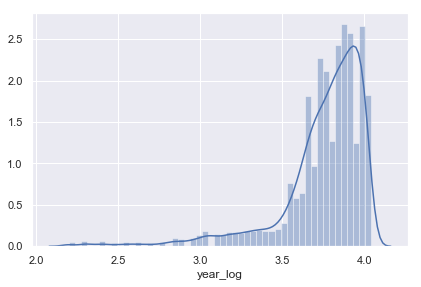

In [277]:
#year_log distribution looks better. tighter distribution 


print(df11['year'].describe())
df11['year_log'] = np.log(df11['year'])
print(df11['year_log'].describe())

df11['year_zscore'] = (df11['year'] - df11['year'].mean())/df11['year'].std()

#view distribution affects of transformations on year
#print(df11['year'].describe())
#sns.distplot(df11['year'])
sns.distplot(df11['year_log'])
#sns.distplot(df11['year_log'])

#drop logged year and year
#z_score looks better than log.
#May come back keep year and implament box-cox later

df11.drop(['year','year_zscore','release_date'],axis=1,inplace=True)


In [278]:
#create dummy vars for month

#print(df11["month"].isna().sum())
#print(df11["month"].notnull().sum())
#print(df11['month'].unique())

cat_names = {1:'Jan', 2:'Feb', 3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
for elem in df11['month'].unique():
    df11[cat_names[elem]] = df11['month'] == elem
    
#drop 1 col for dummy var
df11.drop(['Jan'],axis=1,inplace=True)
df11.drop(['month'],axis=1,inplace=True)

103.0
1
4381


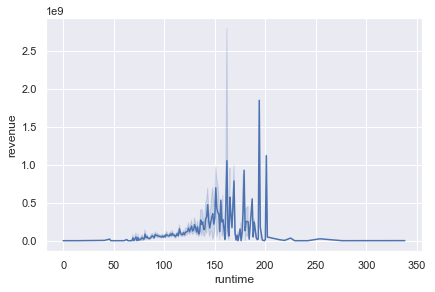

In [279]:
#begin runtime work

#print(df11['runtime'].value_counts())
print(df11['runtime'].median())
print(df11["runtime"].isna().sum())
print(df11["runtime"].notnull().sum())
#print(df11['runtime'].unique())

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ps = sns.lineplot(x='runtime', y="revenue", data=df11)



count    4.382000e+03
mean     1.297203e-16
std      1.000000e+00
min     -4.688428e+00
25%     -6.475681e-01
50%     -1.929714e-01
75%      4.636684e-01
max      1.167705e+01
Name: runtime_zscore, dtype: float64


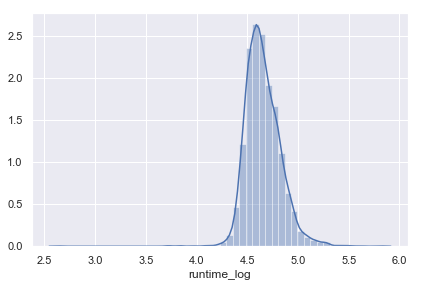

In [280]:
#fill 2 runtime null's with median. 
#if runtime is zero fill with mediam
df11['runtime'] = np.where(df11['runtime'].isnull(), df11['runtime'].median(), df11['runtime'])
df11['runtime'] = np.where(df11['runtime']== 0, df11['runtime'].median() , df11['runtime'])

df11['runtime_log'] = np.log(df11['runtime'])
df11['runtime_zscore'] = (df11['runtime'] - df11['runtime'].mean())/df11['runtime'].std()

#view distribution affects of transformations on year
print(df11['runtime_zscore'].describe())
#sns.distplot(df11['runtime_zscore'])
#sns.distplot(df11['runtime'])
sns.distplot(df11['runtime_log'])


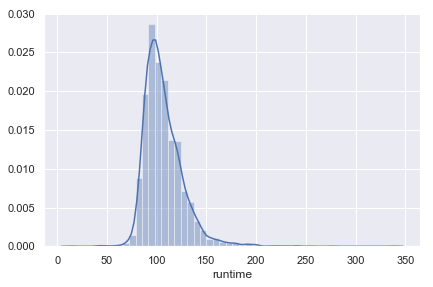

In [281]:
sns.distplot(df11['runtime'])

In [282]:
#drup unused
#print(df11.columns)
df11.drop(['runtime','runtime_zscore'],axis=1,inplace=True)

United States of America    3812
United Kingdom               606
Germany                      277
Canada                       253
France                       215
Australia                    106
Spain                         49
Italy                         47
Japan                         38
Ireland                       36
India                         33
China                         28
New Zealand                   28
Hong Kong                     20
Czech Republic                19
South Africa                  19
Belgium                       15
Mexico                        15
United Arab Emirates          14
Switzerland                   14
Netherlands                   12
Hungary                       12
Denmark                       10
Luxembourg                     9
Sweden                         9
Romania                        8
Norway                         8
Russia                         8
South Korea                    6
Iceland                        5
          

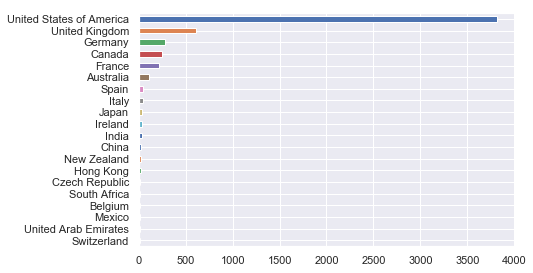

In [283]:
#spoken languages. pivot
v4 = df11.production_countries.apply(json.loads)

df12 = pd.DataFrame(
{
    'id' : df11['id'].values.repeat(v4.str.len(), axis=0),
    'production_countries' : np.concatenate(v4.tolist())
})
#print(df12.head())

df12['production_countries'] = df12['production_countries'].map(lambda x: x.get('name'))

print(df12['production_countries'].value_counts())

counts = df12['production_countries'].value_counts()
ax = counts.iloc[:20].plot(kind="barh")
ax.invert_yaxis()

In [284]:
df12['count']=df12.groupby("production_countries")['production_countries'].transform('count')

df12[["count"]] = df12[["count"]].apply(pd.to_numeric)

#df13 = df12[df12['count'] > 20]
df13=df12

#print(df13['production_countries'].unique())
#print(df13['production_countries'].value_counts())

#no nulls to fill
print(df13['production_countries'].isna().sum())

#One hot encode production companies
ohe4 = df13.set_index('id')\
        .production_countries.str.get_dummies()\
        .sum(level=0)\

#print(ohe4)

#get all columns
cols = ohe4.columns.tolist()
print(cols)

#merge OHE4 prod_countries with df
df14= pd.merge(df11, ohe4, on='id', how='left')

0
['Algeria', 'Angola', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Dominican Republic', 'Fiji', 'Finland', 'France', 'Germany', 'Greece', 'Guyana', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Libyan Arab Jamahiriya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Malta', 'Mexico', 'Monaco', 'Morocco', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Serbia and Montenegro', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Tunisia', 'United Arab Emirates', 'United Kingdom', 'United States of America']


In [285]:
#drop old column 
df14.drop(['production_countries'], inplace=True, axis=1)

print(df14.shape)

#print(ohe4)
#print(df14.tail())
#print(df11["month"].isna().sum())
#print(df11["month"].notnull().sum())
#print(df12['production_countries'].value_counts().sort_values())

(4382, 334)


In [286]:
#drop one column for dummy vars
df14.drop(['United States of America'], inplace=True, axis=1)

In [287]:
#fill na. dropping USA. inherantly null will take the value of USA once 0 is imputed.
df14.update(df14[['Algeria', 'Angola', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Belgium', 'Bhutan',
                  'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Cameroon', 'Canada', 'Chile',
                  'China', 'Colombia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Dominican Republic', 'Fiji', 
                  'Finland', 'France', 'Germany', 'Greece', 'Guyana', 'Hong Kong', 'Hungary', 'Iceland', 'India', 
                  'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
                  'Libyan Arab Jamahiriya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Malta', 'Mexico', 'Monaco',
                  'Morocco', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Peru', 
                  'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Serbia and Montenegro',
                  'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
                  'Taiwan', 'Thailand', 'Tunisia', 'United Arab Emirates', 'United Kingdom']].fillna(0))

In [288]:
#begin work on target

print(df14['revenue'].describe())

#no nulls 
print(df14['revenue'].isna().sum())

#potentially fill 0 with median or drop 0 
print('median: ')
print(df14['revenue'].median())

df_0 = df14.revenue == 0

df_0.value_counts()

#opted against filling 0 revenue with median revenue.
#It doesn't make sense that revenue is 0. 
#I've decided to drop these 0 values
#fill 0 revenue with median
#df14['revenue'] = np.where(df14['revenue']== 0, df11['revenue'].median() , df11['revenue'])
df14.drop(df14[df14.revenue == 0].index, inplace=True)

count    4.382000e+03
mean     8.809327e+07
std      1.687387e+08
min      0.000000e+00
25%      0.000000e+00
50%      2.311311e+07
75%      1.004265e+08
max      2.787965e+09
Name: revenue, dtype: float64
0
median: 
23113112.5


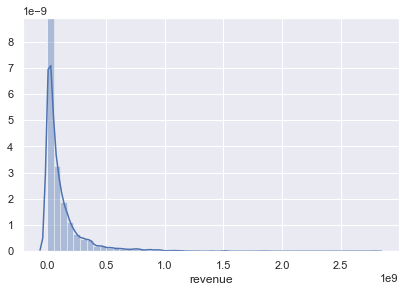

In [289]:
sns.distplot(df14['revenue'])

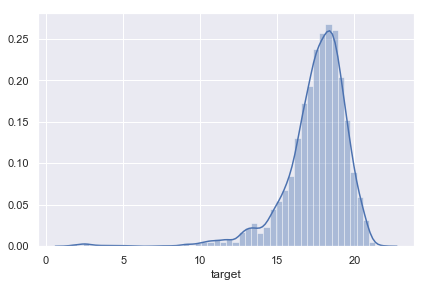

In [290]:
df14['target'] = np.log(df14['revenue'])
sns.distplot(df14['target'])

In [291]:
#target_log has a better distribution 
df14.drop(['revenue'], inplace=True, axis=1)

In [292]:
#Again filtering for only data produced in English
df15 = df14[df14['English'] == 1]

df16 = df15[['Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','year_log','target',
            'Afrikaans', 'Bahasa indonesia', 'Bamanankan', 'Bosanski', 'Català', 'Cymraeg', 'Dansk', 'Deutsch', 
                  'Eesti', 'English', 'Español', 'Esperanto', 'Français', 'Gaeilge', 'Galego', 'Hrvatski', 'Italiano',
                  'Kiswahili', 'Latin', 'Magyar', 'Nederlands', 'No Language', 'Norsk', 'Polski', 'Português', 'Pусский',
                  'Română', 'Slovenčina', 'Slovenščina', 'Somali', 'Srpski', 'Tiếng Việt', 'Türkçe', 'Wolof', 'isiZulu',
                  'shqip', 'suomi', 'svenska', 'Íslenska', 'Český', 'ελληνικά', 'Український', 'български език', 'қазақ',
                  'עִבְרִית', 'اردو', 'العربية', 'فارسی', 'پښتو', 'हिन्दी', 'বাংলা', 'ਪੰਜਾਬੀ', 'தமிழ்', 'తెలుగు', 'ภาษาไทย', 
                  'ქართული', '广州话 / 廣州話', '日本語', '普通话', '한국어/조선말']]
df16.shape

(3103, 73)

In [293]:
from sklearn.model_selection import train_test_split

#train and test sets 
X_train, X_test, y_train, y_test = train_test_split(df16.drop('target',axis=1), 
                                                    df16['target'], test_size=0.20, 
                                                    random_state=111)

In [294]:
print('After split: ')
print('x_train shape: %s ' % str(X_train.shape))
print('y_train shape: %s' % str(y_train.shape))
print('x_test shape: %s' % str(X_test.shape))
print('y_test shape: %s' % str(y_test.shape))

After split: 
x_train shape: (2482, 72) 
y_train shape: (2482,)
x_test shape: (621, 72)
y_test shape: (621,)


In [295]:
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adam
from keras.losses import mean_squared_error
from keras.initializers import RandomNormal
from math import sqrt
from tensorflow.random import set_random_seed
from keras import utils

In [296]:
set_random_seed(764)
def train(X_train,
          y_train,
          X_test, 
          y_test,
          epochs, 
          batch_size, 
          hidden_layer_nodes, 
          hidden_activation, 
          hidden_dropout, 
          regularizer,
          optimizer,
          initializer
          ):

    model = Sequential()
    
    model.add(Dense(hidden_layer_nodes[0],
                    input_dim=72,
                    activation = hidden_activation,
                    kernel_initializer = initializer,
                    kernel_regularizer = regularizer,
                    bias_initializer='zeros'))
    
    if (hidden_dropout > 0):
        model.add(Dropout(hidden_dropout))
    
    for i in range(1, len(hidden_layer_nodes)):
        model.add(
            Dense(hidden_layer_nodes[i], 
                activation = hidden_activation, 
                kernel_initializer=initializer, 
                kernel_regularizer = regularizer,
                bias_initializer='zeros'))
        
        if (hidden_dropout > 0):
            model.add(Dropout(hidden_dropout))
    
    model.add(Dense(1, kernel_initializer=initializer))
    
    model.compile(loss=mean_squared_error, optimizer = optimizer,metrics=['accuracy'])
    
    trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_test, y_test), verbose=1)
    
    return trained, model

Train on 2482 samples, validate on 621 samples
Epoch 1/100
2482/2482 [==============================] - 2s 767us/step - loss: 318.4884 - acc: 0.0000e+00 - val_loss: 316.3355 - val_acc: 0.0000e+00
Epoch 2/100
2482/2482 [==============================] - 0s 49us/step - loss: 311.6823 - acc: 0.0000e+00 - val_loss: 309.7241 - val_acc: 0.0000e+00
Epoch 3/100
2482/2482 [==============================] - 0s 109us/step - loss: 304.7162 - acc: 0.0000e+00 - val_loss: 302.2307 - val_acc: 0.0000e+00
Epoch 4/100
2482/2482 [==============================] - 0s 127us/step - loss: 296.9162 - acc: 0.0000e+00 - val_loss: 293.5383 - val_acc: 0.0000e+00
Epoch 5/100
2482/2482 [==============================] - 0s 104us/step - loss: 287.8902 - acc: 0.0000e+00 - val_loss: 283.3207 - val_acc: 0.0000e+00
Epoch 6/100
2482/2482 [==============================] - 0s 72us/step - loss: 277.2713 - acc: 0.0000e+00 - val_loss: 271.2848 - val_acc: 0.0000e+00
Epoch 7/100
2482/2482 [==============================] - 0s 7

2482/2482 [==============================] - 0s 72us/step - loss: 16.9572 - acc: 0.0000e+00 - val_loss: 10.7332 - val_acc: 0.0000e+00
Epoch 57/100
2482/2482 [==============================] - 0s 49us/step - loss: 17.4866 - acc: 0.0000e+00 - val_loss: 10.6117 - val_acc: 0.0000e+00
Epoch 58/100
2482/2482 [==============================] - 0s 63us/step - loss: 17.6033 - acc: 0.0000e+00 - val_loss: 10.8440 - val_acc: 0.0000e+00
Epoch 59/100
2482/2482 [==============================] - 0s 49us/step - loss: 17.1340 - acc: 0.0000e+00 - val_loss: 10.5482 - val_acc: 0.0000e+00
Epoch 60/100
2482/2482 [==============================] - 0s 63us/step - loss: 17.3160 - acc: 0.0000e+00 - val_loss: 10.8062 - val_acc: 0.0000e+00
Epoch 61/100
2482/2482 [==============================] - 0s 68us/step - loss: 16.9188 - acc: 0.0000e+00 - val_loss: 10.6966 - val_acc: 0.0000e+00
Epoch 62/100
2482/2482 [==============================] - 0s 39us/step - loss: 16.9623 - acc: 0.0000e+00 - val_loss: 10.3577 - val_

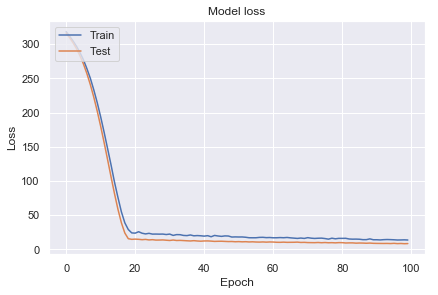

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 4)                 292       
_________________________________________________________________
dropout_35 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_36 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 5         
Total params: 317
Trainable params: 317
Non-trainable params: 0
_________________________________________________________________


In [297]:
#Set some hyperparameters
epochs = 100
batch_size = 500
hidden_layer_nodes = [4,4]
hidden_activation = 'relu'
hidden_dropout = .03
regularizer = l2(.1)
optimizer = SGD(lr=.5, clipnorm=.05)
initializer = RandomNormal(mean=0, stddev=.5, seed=764)
    
trained, model = train(X_train, y_train, X_test, y_test, epochs, 
      batch_size, hidden_layer_nodes, hidden_activation, 
      hidden_dropout, regularizer, optimizer, initializer)


# Plot training & validation loss values
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

model.summary()

Variance score: -0.2868383592542221


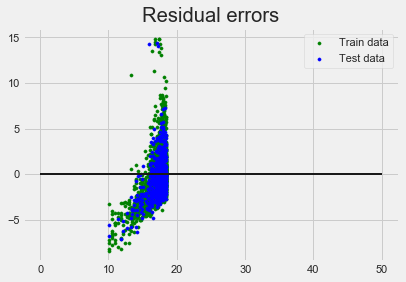

In [298]:
#lasso reg
reg = linear_model.Lasso(alpha=1, max_iter=1000,fit_intercept=False) 
reg.fit(X_train, y_train)

# regression coefficients 
#print('Coefficients: \n', reg.coef_) 

# variance score: 1 means perfect prediction 
print('Variance score: {}'.format(reg.score(X_test, y_test))) 

# plot for residual error 
## setting plot style 
plt.style.use('fivethirtyeight') 

## plotting residual errors in training data 

plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, 
            color = "green", s = 10, label = 'Train data') 

## plotting residual errors in test data 

plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Test data') 

## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2) 

## plotting legend 
plt.legend(loc = 'upper right') 

## plot title 
plt.title("Residual errors") 

## function to show plot 
plt.show() 


Variance score: 0.09305820131746834


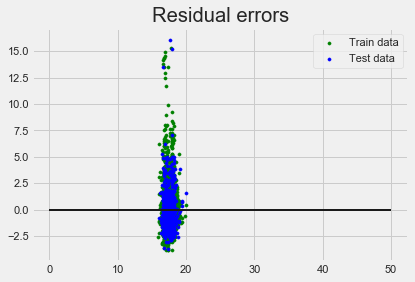

In [299]:
#Ridge reg
reg = linear_model.Ridge(alpha=[5]) 
reg.fit(X_train, y_train)

# regression coefficients 
#print('Coefficients: \n', reg.coef_) 

# variance score: 1 means perfect prediction 
print('Variance score: {}'.format(reg.score(X_test, y_test))) 

# plot for residual error 
## setting plot style 
plt.style.use('fivethirtyeight') 

## plotting residual errors in training data 

plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, 
            color = "green", s = 10, label = 'Train data') 

## plotting residual errors in test data 

plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Test data') 

## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2) 

## plotting legend 
plt.legend(loc = 'upper right') 

## plot title 
plt.title("Residual errors") 

## function to show plot 
plt.show() 

Variance score: 0.09305820131746667


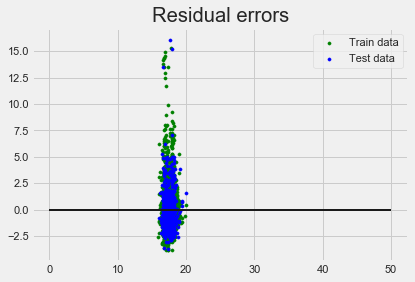

In [300]:
#ridge with cross validation

#Ridge Reg
reg = RidgeCV(alphas=[.001,.01,.1,.5,1,1.5,2,2.5,3,3.5,4,4.5,5]).fit(X_train, y_train)
reg.score(X_test, y_test)

# variance score: 1 means perfect prediction 
print('Variance score: {}'.format(reg.score(X_test, y_test))) 

# plot for residual error 
## setting plot style 
plt.style.use('fivethirtyeight') 

## plotting residual errors in training data 

plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, 
            color = "green", s = 10, label = 'Train data') 

## plotting residual errors in test data 

plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Test data') 

## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2) 

## plotting legend 
plt.legend(loc = 'upper right') 

## plot title 
plt.title("Residual errors") 

## function to show plot 
plt.show() 

In [303]:
%history -n 0-226 #-n for output as well 

   0: 
   1:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import json
import keras

#Import dataset
bf_file = 'C:/Users/Greg/Downloads/Movie_Revenue_Predictions.csv'
df = pd.read_csv(bf_file)
   2: v = df.genres.apply(json.loads)
   3:
#Inspect Json load of generes
#v.head()
#Inspect import element
#df.head()
#df.columns
df.shape
   4:
#Import genere and id into dataframe
df2 = pd.DataFrame(
{
    'id' : df['id'].values.repeat(v.str.len(), axis=0),
    'genre' : np.concatenate(v.tolist())
})
#Inspect element
df2.head()
   5:
#Extract name element
df2['genre'] = df2['genre'].map(lambda x: x.get('name'))

#Inspect element
print('Shape: ')
print(df2.shape)
print('unique: ')
print(df2['genre'].unique())
print('describe: ')
print(df2['genre'].describe())

#seaborn left horzontal bar, counts
counts = df2['genre'].value_counts()
ax = counts.iloc[:20].plot(kind="barh")
ax.invert_yaxis()
   6:

#One hot encode genre
ohe = df2.set_index('id')\
   